https://basedosdados.github.io/mais/api_reference_python/


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



dataset_id: 
	br-cvm-oferta-publica-distribuicao 
description: 
	Ofertas de distribuição (ações, fundos, debêntures, CRI, etc) registradas ou dispensadas 
registro. 
-----------------------------------------------------------------------------------------------
dataset_id: 
	br-bd-indicadores 
description: 
	Indicadores da Base dos Dados enquanto organização sem fins lucrativos. 
-----------------------------------------------------------------------------------------------
dataset_id: 
	br-rj-isp-estatisticas-seguranca 
description: 
	O Instituo de Segurança Pública do Rio de Janeiro (ISP) fornece bases de dados 
registros criminais e de atividade policial. As estatísticas divulgadas são construídas 
partir dos Registros de Ocorrência (RO) lavrados nas delegacias da Secretaria de 
de Polícia Civil do Rio de Janeiro (SEPOL), além de informações complementares de 
específicos da Secretaria de Estado de Polícia Militar do Rio de Janeiro (SEPM). 
de serem consolidados no ISP, os RO são s

Downloading: 100%|██████████| 528/528 [00:00<00:00, 1766.09rows/s]


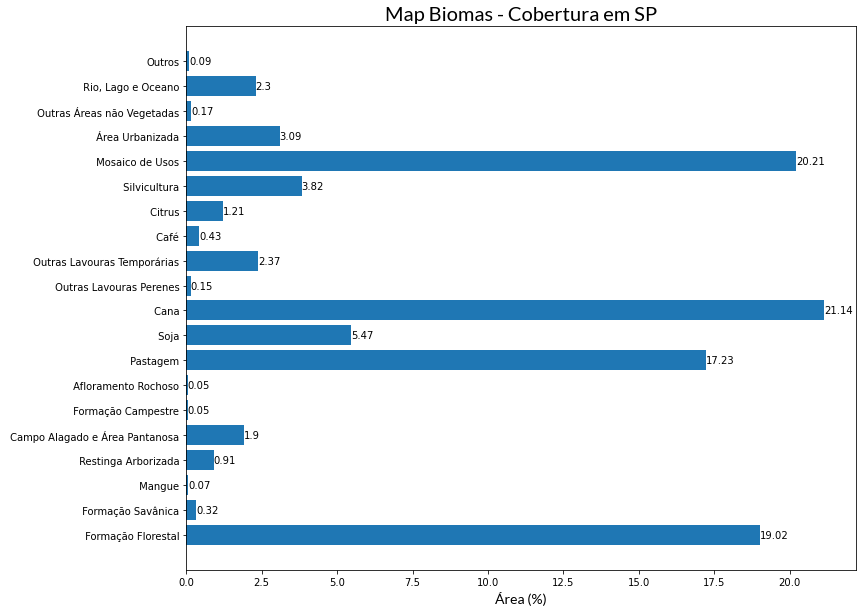

In [2]:
## 1. Instalação/Import

!pip install basedosdados
import basedosdados as bd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Datasets

# Com o `list_datasets()` conseguimos visualizar, em forma de strings, texto, todos os conjuntos de dados disponíveis na base da BD.
bd.list_datasets(with_description=True, verbose=True)

# Vamos escolher o conjunto do MapBiomas e analisar as tabelas que ele possui.
bd.list_dataset_tables('br_mapbiomas_estatisticas',with_description=True,
verbose=True)

# Overview do conjunto de dados
# Função que permite visualizar todas as tabelas e colunas de um conjunto de dados, usando bd.list_dataset_tables e bd.get_table_columns.
def dataset_overview(dataset_id,table_id=None):
    import pandas as pd
    import basedosdados as bd
    # Args:
    #     dataset_id: str: nome do dataset no Datalake da BD
    # Return:
    #    columns: dataframe com todas as tabelas e as respectivas colunas detalhadas
    # Variables:
    #     tables: list of str: nomes das tabelas no dataset
    #     tables_columns: DataFrame: nomes das colunas de cada tabela
    
    tables = bd.list_dataset_tables(dataset_id,verbose=False) 
    table_columns = pd.DataFrame()
    columns = pd.DataFrame()
    
    if table_id==None:
        for table_id in tables:
            table_columns = pd.DataFrame(bd.get_table_columns(dataset_id,table_id,verbose=False))
            table_columns['table_id'] = [table_id]*len(table_columns.index)
            
            if columns.empty:
                columns=table_columns
                
            else:
                columns=pd.concat([columns, table_columns])
    else:
        columns = pd.DataFrame(bd.get_table_columns(dataset_id,table_id,verbose=False))
        
    columns.set_index('table_id',inplace=True,drop=True)
    columns.set_index(pd.MultiIndex.from_arrays([list(columns.index),list(columns['name'])]),inplace=True,drop=True)
    columns.drop('name', axis=1, inplace=True)
    
    return columns



dataset_overview('br_mapbiomas_estatisticas')

'''
Agora que conseguimos visualizar quais tabelas o conjunto tem e os tipos de colunas elas possuem, vamos escolher quais tabelas queremos de fato ler.

Vamos utilizar a tabela **`cobertura_uf_classe`** para visualizar a cobertura de cada estado brasileiro no ano de 2021. Vamos usar também a tabela **`classe`** com os nomes correspondentes a cada chave numérica que identifica um bioma ou classe de cobertura, na coluna **`id_classe`** das demais tabelas.                                                                                         

Para ler essas tabelas, usaremos o método **`bd.read_table()`** do pacote. 
Como argumentos, precisamos do 
- ID do dataset
- ID da tabela
- ID do projeto no BigQuery
'''

## 3. Autenticação

''' 
Você precisa estar vinculado a um usuário no Google Cloud, o sistema de armazenamento de bancos de dados do Google, e ter um projeto no BigQuery 

Se você já tem uma conta e um projeto, basta procurar pelo identificador desse projeto em https://console.cloud.google.com/projectselector2/home/dashboard ...

e usá-lo como uma string no argumento correspondente da função, escrevendo **`billing_project_id = nome do projeto`**.


Caso contrário, crie uma conta no Google Cloud, em https://console.cloud.google.com, e visite https://console.cloud.google.com/projectselector2/home/dashboard 
para criar um novo projeto. Em seguida, procure pelo ID do projeto.
O Google Cloud disponibiliza 1TB em consultas por mês de forma gratuita. Se ultrapassar esse limite, o que é bem difícil de acontecer, 
você poderá ser cobrado para realizar mais consultas. 
'''

df_mapb=bd.read_table(dataset_id='br_mapbiomas_estatisticas',
                      table_id='cobertura_uf_classe',
                      billing_project_id='seu-projeto-billing-id') 

df_classe=bd.read_table(dataset_id='br_mapbiomas_estatisticas',
                        table_id='classe',
                        billing_project_id='seu-projeto-billing-id') 

## 4. Análise
# Analisando a cobertura temporal da tabela de biomas com a função **`unique()`** do pandas sobre a coluna **`ano`**, vemos que os dados mais recentes são de 2021.
unique=list(df_mapb['ano'].unique())
unique.sort()
unique

# Organizando os dados de cada uma das tabelas 
'''
Renomear a coluna "chave" da tabela "df_classe", para que tenha o mesmo nome da coluna "id_classe" da tabela "df_mapb". 
'''
df_classe.rename({"chave":"id_classe"}, axis=1, inplace=True)

# Seleção dos dados de 2021 e JOIN das tabelas sobre a coluna id_classe
df_cobertura = df_mapb[df_mapb['ano']==2021].merge(df_classe,
                                              how='left',
                                               on='id_classe')

# Eliminação de colunas desnecessárias
df_cobertura.drop(['valor_en','ano'], axis=1, inplace=True)
df_cobertura.drop('id_classe', axis=1, inplace=True)

# Novo índice: sigla_uf
df_cobertura.set_index('sigla_uf', inplace=True, drop=True)
df_cobertura


# Organizando o dataframe
'''
Vamos escrever uma função "organize_table()" usa o "groupby()" do pandas para agrupar os dados por estado e por classe de cobertura, e reposicionar os dados.
'''

def organize_table(df):

  df['valor_pt'].fillna(value='Indeterminado',inplace=True)
  # Agrupamento e reindexação  
  df = df.groupby(['sigla_uf','valor_pt']).sum()
  df.round(2)
  df.reset_index(inplace=True)

  # Pivotamento de colunas e linhas
  df = df.pivot(columns='valor_pt',values='area',index='sigla_uf')
  
  # Limpeza dos dados e labels
  df.columns = df.columns.str.replace('[\d\.]+','')
  df.columns.name='Cobertura'
  df.index.name='UF'

  # Valores inválidos como '0'
  df.fillna(value=0,inplace=True)

  return df

df_cobertura = organize_table(df_cobertura)

## 5. Análise com sql ("read_sql()")

query = """SELECT a.sigla_uf, b.valor_pt, a.area
          FROM `basedosdados.br_mapbiomas_estatisticas.cobertura_uf_classe` a
          LEFT OUTER JOIN `basedosdados.br_mapbiomas_estatisticas.classe` b
          ON a.id_classe = b.chave WHERE a.ano = 2021"""

df_mapbiomas = bd.read_sql(query,
             billing_project_id='seu-projeto-billing-id') 

df_mapbiomas = organize_table(df_mapbiomas)

## 6. Visualizações
def dataframe_estado(sigla_uf, dataframe):
    df_estado = dataframe.loc[sigla_uf]
    df_estado = df_estado[df_estado.values!=0]
   
    
    # Mostrar apenas áreas superiores a 10% da média (o restante é agrupado em 'Outros')
    filtro=0.01*df_estado.mean()
    labels = list(df_estado[df_estado.values>filtro].index)
    labels.append('Outros')
    

    data = list(df_estado[df_estado.values>filtro].values)
    data.append(df_estado[df_estado.values<=filtro].sum())

    # Área percentual
    data=data/df_estado.sum()*100
    data=data.round(2)   

    plt.figure(figsize = (12,10))
  
    ######################################################################
    # Gráficos
    paleta = [ '#16a085','#c0392b', '#8e44ad', '#27ae60', '#e67e22', '#f1c40f', '#d35400', '#2980b9', '#2ecc71', 
              '#7f8c8d', '#e74c3c', '#9b59b6', '#2c3e50']

    plot = plt.barh(labels, data, height=0.8)
    axs=plt.gca()

    # Adicionar um título ao gráfico
    if sigla_uf in ['GO','MG','SP','SE','SC','RR','RO','PE','AL']:
        prepost_str = ' em '
    elif sigla_uf in ['BA','PB']:
        prepost_str = ' na '
    else:
        prepost_str = ' no '
  

    font = {'family': 'Lato', 'size': 14}
    axs.set_title('Map Biomas - Cobertura'+prepost_str+sigla_uf,
                  fontname='Lato', fontsize=20)
    axs.bar_label(plot)
    
    
    axs.set_xlabel('Área (%)', fontdict=font)
    return axs

axs=dataframe_estado('SP',df_mapbiomas)
